In [4]:
# 02_model_baselines.ipynb
# Train baseline models on the processed UCI diabetes cohort

import sys
import os
import numpy as np
import pandas as pd

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from src.train import split_data
from src.models_baseline import train_logreg, train_logreg_l1
import matplotlib.pyplot as plt

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Shape:", df.shape)
df.head()

Shape: (25000, 64)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,on_diabetes_med,med_up,med_down,...,diag_3_Respiratory,diag_3_nan,glucose_test_high,glucose_test_no,glucose_test_normal,glucose_test_nan,A1Ctest_high,A1Ctest_no,A1Ctest_normal,A1Ctest_nan
0,8,72,1,18,2,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,3,34,2,13,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2,5,45,0,18,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
3,2,36,0,12,1,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,42,0,7,0,0,0,0,0,0,...,True,False,False,True,False,False,False,True,False,False


In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



def check_null(data):
    if data.isnull().sum().sum():
        print("There are nulls in the data")
        print(data.isnull().sum())
        print("Data size before : " , data.size)
        # As main idea is to make code reusable and train different ml models
        data = data.dropna()
        print("Data size after : " , data.size)
        
    else:
        print("There are no nulls in the data.")

    return data
def cat_int_cols(data, target):
    # data = data.drop(target, axis=1)
    cat_col = data.select_dtypes(include=['object']).columns
    int_col = data.select_dtypes(include=['int64', 'float64']).columns
    return cat_col, int_col

def encode_target_bin(data, col):
    print(f"{data[col].unique()[-1]} is encoded as 0, and {data[col].unique()[-2]} is encoded as 1")
    data[col] = data[col].map({data[col].unique()[-1]:0, data[col].unique()[-2]:1})
    data[col] = data[col].astype(int)

def encode_cat(data, cols, int_coll):
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    encoded = ohe.fit_transform(data[cols])
    encoded_col = ohe.get_feature_names_out(cols)
    data_updated = pd.DataFrame(encoded, columns=encoded_col, index=data.index)
    data = pd.concat([data[int_coll], data_updated], axis=1)
    return data

def data_split(data, target, stan=False):
    X = data.drop(target, axis=1)
    Y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    if stan:
        X_train, X_test = Standard(X_train, X_test)

    return X_train, X_test, y_train, y_test 
def Standard(train, test):
    st = StandardScaler()
    train = st.fit_transform(train)
    test = st.transform(test)
    return train, test


hosp = pd.read_csv("../data_raw/diabetic_data.csv")   
target3 = "readmitted"
hosp = check_null(hosp)
encode_target_bin(hosp, target3)

cat_col, int_col = cat_int_cols(hosp, target3)

hosp = encode_cat(hosp, cat_col, int_col)
hosp.head()

X_train, X_test, y_train, y_test = data_split(hosp, target3)

X_train, X_test = Standard(X_train, X_test)

lr2 = LogisticRegression()
lr2.fit(X_train, y_train)

y_pred = lr2.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def performance(pred, actual):
    acc = accuracy_score(pred, actual)
    prec = precision_score(pred, actual)
    rec = recall_score(pred, actual)
    f1 = f1_score(pred, actual)
    con = confusion_matrix(pred, actual)
    return acc, prec, rec, f1


acc, prec, rec, f1 = performance(y_pred, y_test)
print("Precision Score is ; ", prec)
print("Recall Score is ; ", rec)
print("F1-Score Score is ; ", f1)


There are no nulls in the data.
yes is encoded as 0, and no is encoded as 1
Precision Score is ;  0.7836719337848006
Recall Score is ;  0.6023713128976287
F1-Score Score is ;  0.6811641595814257


In [6]:
label_col = "label"

X = df.drop(columns=[label_col, "encounter_id", "patient_nbr"])
y = df[label_col]

print("Feature matrix:", X.shape)
print("Positive rate (label=1):", y.mean())

KeyError: "['encounter_id', 'patient_nbr'] not found in axis"

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# Make sure we dropped ID columns from all splits
drop_cols = ["encounter_id", "patient_nbr", label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

X_train.shape, X_val.shape, X_test.shape

((17500, 63), (3750, 63), (3750, 63))

In [8]:
def eval_model(model, X, y, set_name="val"):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
    else:
        # fallback: use decision_function then squish
        scores = model.decision_function(X)
        # simple min-max scale as pseudo-prob
        probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

    preds = (probs >= 0.5).astype(int)

    metrics = {
        "set": set_name,
        "AUROC": roc_auc_score(y, probs),
        "AUPRC": average_precision_score(y, probs),
        "Accuracy": accuracy_score(y, preds),
    }
    return metrics, preds, probs

In [9]:
logreg = train_logreg(X_train, y_train)
logreg_l1 = train_logreg_l1(X_train, y_train)
logreg_metrics_val, logreg_preds_val, logreg_probs_val = eval_model(
    logreg, X_val, y_val, "val"
)
logreg_metrics_test, logreg_preds_test, logreg_probs_test = eval_model(
    logreg, X_test, y_test, "test"
)

logreg_l1_metrics_val, logreg_l1_preds_val, logreg_l1_probs_val = eval_model(
    logreg_l1, X_val, y_val, "val"
)
logreg_l1_metrics_test, logreg_l1_preds_test, logreg_l1_probs_test = eval_model(
    logreg_l1, X_test, y_test, "test"
)

logreg_metrics_val, logreg_metrics_test

({'set': 'val',
  'AUROC': 0.6395904062737916,
  'AUPRC': 0.6152128587692858,
  'Accuracy': 0.6088},
 {'set': 'test',
  'AUROC': 0.6413896795420946,
  'AUPRC': 0.6217641517740159,
  'Accuracy': 0.6112})

In [11]:
results_val = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_val},
    {"model": "LogReg_L1", **logreg_l1_metrics_val},
]).set_index("model")

results_test = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_test},
    {"model": "LogReg_L1", **logreg_l1_metrics_test},
]).set_index("model")

print("Validation:")
display(results_val)

print("\nTest:")
display(results_test)

Validation:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,val,0.639590,0.615213,0.608800
LogReg_L1,val,0.639777,0.615299,0.609333



Test:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,test,0.641390,0.621764,0.611200
LogReg_L1,test,0.641512,0.621859,0.612267


Confusion matrix (test, L2 Logistic Regression):
[[1408  579]
 [ 879  884]]


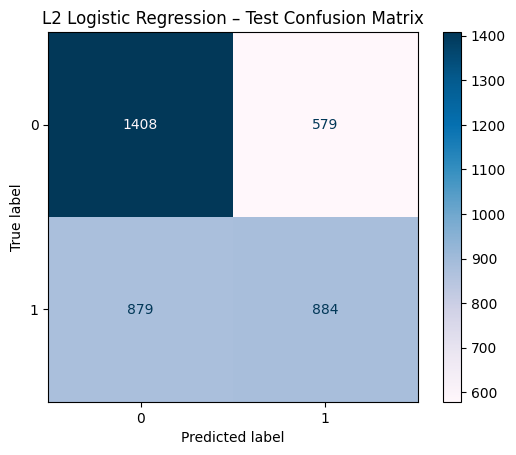

Classification report (test, L2 Logistic Regression):
              precision    recall  f1-score   support

           0      0.616     0.709     0.659      1987
           1      0.604     0.501     0.548      1763

    accuracy                          0.611      3750
   macro avg      0.610     0.605     0.603      3750
weighted avg      0.610     0.611     0.607      3750



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_preds = logreg_preds_test
test_labels = y_test

cm = confusion_matrix(test_labels, test_preds)
print("Confusion matrix (test, L2 Logistic Regression):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("L2 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L2 Logistic Regression):")
print(classification_report(test_labels, test_preds, digits=3))

Confusion matrix (test, L1 Logistic Regression):
[[1413  574]
 [ 880  883]]


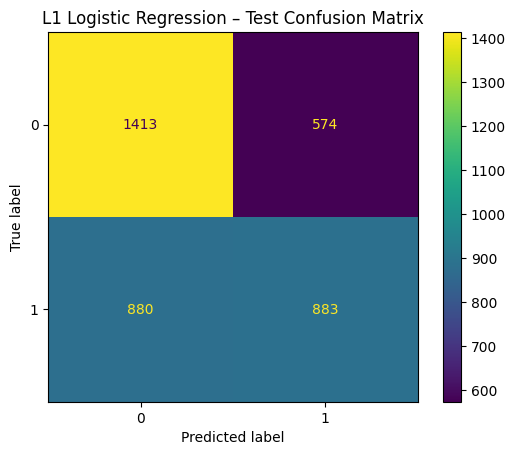

Classification report (test, L1 Logistic Regression):
              precision    recall  f1-score   support

           0      0.616     0.711     0.660      1987
           1      0.606     0.501     0.548      1763

    accuracy                          0.612      3750
   macro avg      0.611     0.606     0.604      3750
weighted avg      0.611     0.612     0.608      3750



In [13]:
cm_l1 = confusion_matrix(y_test, logreg_l1_preds_test)
print("Confusion matrix (test, L1 Logistic Regression):")
print(cm_l1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_l1, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("L1 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L1 Logistic Regression):")
print(classification_report(y_test, logreg_l1_preds_test, digits=3))

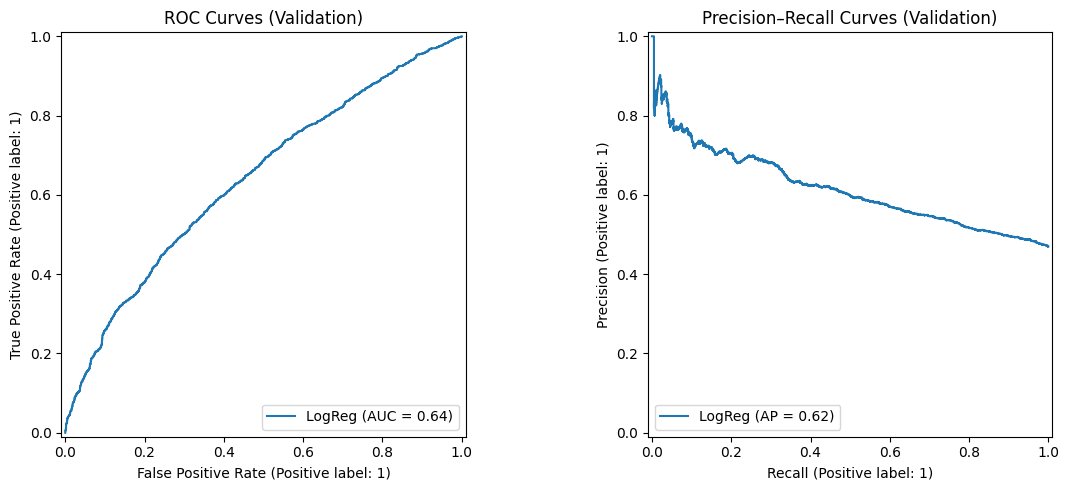

In [14]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[0], name="LogReg")
axes[0].set_title("ROC Curves (Validation)")

PrecisionRecallDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[1], name="LogReg")
axes[1].set_title("Precision–Recall Curves (Validation)")

plt.tight_layout()
plt.show()